#### Before running this notebook:
- Create an empty folder `processed_data`
- Run `evaluate_benchmarks.ipynb` until the cell block that saves `c10h_labels`, `c10h_true_labels`, and `pred_probs` to `.npy` files, make sure those files are saved into your local directory
- Run this notebook

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
sys.path.insert(0, "../")

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, \
                            roc_curve, accuracy_score, log_loss, precision_recall_fscore_support
from matplotlib import pyplot as plt
from IPython.display import Image, display
from scipy import stats

# cleanlab imports
import cleanlab
from cleanlab.multiannotator import get_label_quality_multiannotator, get_multiannotator_stats # only in hui wen directory
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
from cleanlab.filter import find_label_issues

# local imports
from utils.eval_metrics import lift_at_k
from utils.active_learning_scores import least_confidence
# experimental version of label quality ensemble scores with additional weighting schemes
from utils.label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

import warnings
warnings.filterwarnings("ignore")

path = os.getcwd()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

fig_size_small = (5, 8)
fig_size_big = (15,10)

In [9]:
c10h_labels = np.load("processed_data/c10h_labels.npy")
c10h_true_labels = np.load("processed_data/c10h_true_labels.npy")
pred_probs = np.load("processed_data/pred_probs.npy")
model = "resnet18"

In [3]:
params_quality = [
    "auto",
    "lqs",
    "agreement",
    "active_label_cleaning",
    "bayes",
]

params_consensus =[
    "majority",
    "dawid_skene",
]

In [16]:
def benchmark_results_consensus(c10h_labels, c10h_true_labels, pred_probs, consensus_methods, model):
    plt.rcParams["figure.figsize"] = fig_size_big    
    results = []
    results_list = []
    
    c10h_labels = pd.DataFrame(c10h_labels)

    for method in consensus_methods:
        label_quality_multiannotator, _ = get_label_quality_multiannotator(c10h_labels, pred_probs, consensus_method=method, return_annotator_stats = True, verbose=False)
        # create boolean mask of label errors
        labels = label_quality_multiannotator['consensus_label'] 
        label_errors_target = labels != c10h_true_labels # labels can change to annotator labels!!
        # compute scores
        label_quality_scores = label_quality_multiannotator['quality_of_consensus']
        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
        # compute Lift@K evaluation metric
        lift_at_k_dict = {}
        for k in range(1000, 11000, 1000):
            lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)
        # save results
        results = {
            "dataset": "cifar10",
            "model": model,
            "noise_config": "nan",
            "method": method,
            # "adjust_pred_probs": adjust_pred_probs,
            "auroc": auroc
        }
        # add the lift at k metrics
        results.update(lift_at_k_dict)
        # save results
        results_list.append(results)

        # compute precision-recall curve using label quality scores
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # compute au-roc curve using label quality scores
        fpr, tpr, thresholds = roc_curve(label_errors_target,  1 - label_quality_scores)

        precision_recall_curve_results = {
            "method": method,
            # "adjust_pred_probs": adjust_pred_probs,
            "dataset": "cifar10",
            "model": model,
            "label_quality_scores": label_quality_scores,
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds
        }
        
        # plot prc
        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, label=f"{method}")
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.title("Precision-Recall Curve \n Model: resnet-18", fontsize=14, fontweight="bold")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, label=f"{method}")
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title("AU ROC Curve \n Model: resnet-18", fontsize=14, fontweight="bold")
        plt.legend()
        
    return results_list, precision_recall_curve_results

In [17]:
def benchmark_results_quality(c10h_labels, c10h_true_labels, pred_probs, quality_methods, model):
    plt.rcParams["figure.figsize"] = fig_size_big    
    results = []
    results_list = []
    
    c10h_labels = pd.DataFrame(c10h_labels)

    for method in quality_methods:
        label_quality_multiannotator, _ = get_label_quality_multiannotator(c10h_labels, pred_probs, quality_method=method, return_annotator_stats = True, verbose=False)
        # create boolean mask of label errors
        labels = label_quality_multiannotator['consensus_label'] 
        label_errors_target = labels != c10h_true_labels # labels can change to annotator labels!!
        # compute scores
        label_quality_scores = label_quality_multiannotator['quality_of_consensus']
        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
        # compute Lift@K evaluation metric
        lift_at_k_dict = {}
        for k in range(1000, 11000, 1000):
            lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)
        # save results
        results = {
            "dataset": "cifar10",
            "model": model,
            "noise_config": "nan",
            "method": method,
            # "adjust_pred_probs": adjust_pred_probs,
            "auroc": auroc
        }
        # add the lift at k metrics
        results.update(lift_at_k_dict)
        # save results
        results_list.append(results)

        # compute precision-recall curve using label quality scores
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # compute au-roc curve using label quality scores
        fpr, tpr, thresholds = roc_curve(label_errors_target,  1 - label_quality_scores)

        precision_recall_curve_results = {
            "method": method,
            # "adjust_pred_probs": adjust_pred_probs,
            "dataset": "cifar10",
            "model": model,
            "label_quality_scores": label_quality_scores,
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds
        }
        
        # plot prc
        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, label=f"{method}")
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.title("Precision-Recall Curve \n Model: resnet-18", fontsize=14, fontweight="bold")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, label=f"{method}")
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title("AU ROC Curve \n Model: resnet-18", fontsize=14, fontweight="bold")
        plt.legend()
        
    return results_list, precision_recall_curve_results

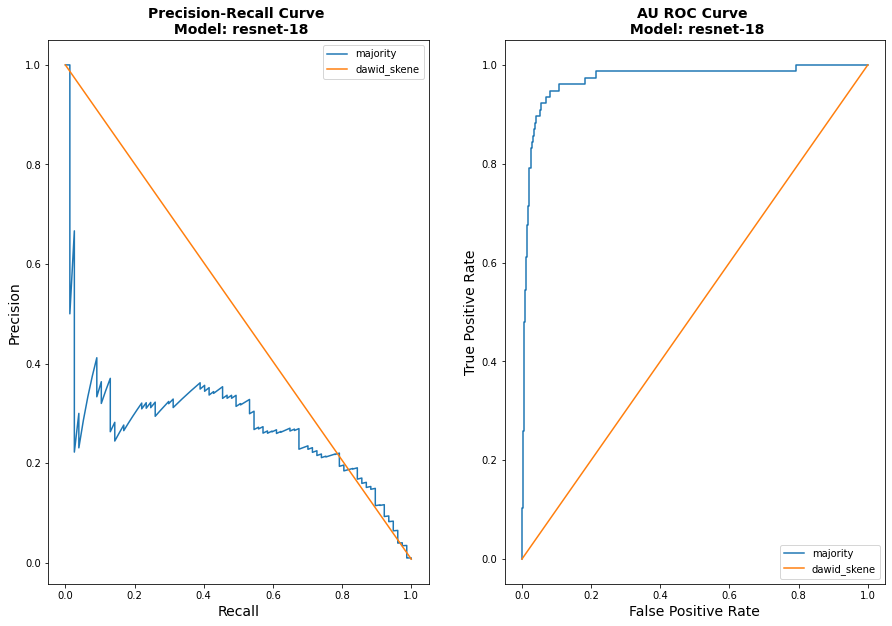

In [18]:
results_list_consensus, precision_recall_curve_results_consensus = benchmark_results_consensus(c10h_labels, c10h_true_labels, pred_probs, params_consensus, model)

In [19]:
pd.DataFrame(results_list_consensus)

,dataset,model,noise_config,method,auroc,lift_at_1000,lift_at_2000,lift_at_3000,lift_at_4000,lift_at_5000,lift_at_6000,lift_at_7000,lift_at_8000,lift_at_9000,lift_at_10000
0,cifar10,resnet18,nan,majority,0.970096,9.480519,4.870130,3.290043,2.467532,1.974026,1.645022,1.410019,1.250000,1.111111,1.0
1,cifar10,resnet18,nan,dawid_skene,0.500000,0.410959,0.547945,0.821918,0.787671,1.068493,1.004566,0.880626,0.856164,0.928463,1.0


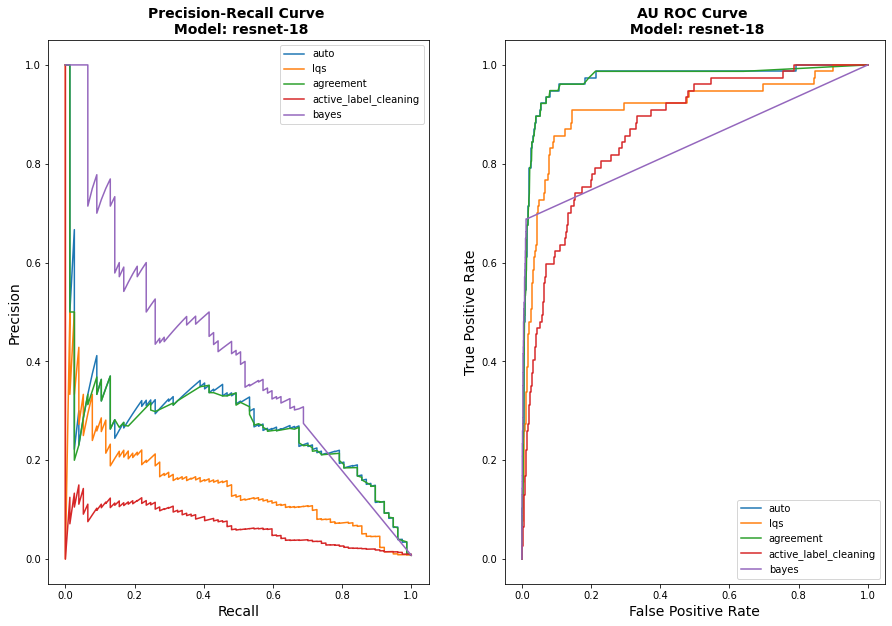

In [20]:
results_list_quality, precision_recall_curve_results_quality = benchmark_results_quality(c10h_labels, c10h_true_labels, pred_probs, params_quality, model)

In [21]:
pd.DataFrame(results_list_quality)

,dataset,model,noise_config,method,auroc,lift_at_1000,lift_at_2000,lift_at_3000,lift_at_4000,lift_at_5000,lift_at_6000,lift_at_7000,lift_at_8000,lift_at_9000,lift_at_10000
0,cifar10,resnet18,nan,auto,0.970096,9.480519,4.870130,3.290043,2.467532,1.974026,1.645022,1.410019,1.250000,1.111111,1.0
1,cifar10,resnet18,nan,lqs,0.910540,8.571429,4.545455,3.073593,2.305195,1.896104,1.580087,1.372913,1.201299,1.111111,1.0
2,cifar10,resnet18,nan,agreement,0.969654,9.480519,4.870130,3.290043,2.467532,1.974026,1.645022,1.410019,1.233766,1.111111,1.0
3,cifar10,resnet18,nan,active_label_cleaning,0.868676,6.103896,3.766234,2.813853,2.272727,1.896104,1.623377,1.391466,1.250000,1.111111,1.0
4,cifar10,resnet18,nan,bayes,0.839213,6.883117,3.571429,2.554113,2.077922,1.792208,1.493506,1.280148,1.152597,1.038961,1.0
